In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import fitsio
import glob

import numpy as np
import healpy as hp
import xlens
import treecorr
import astropy.table as astTable
import numpy.lib.recfunctions as rfn
from lsst.geom import degrees
from scipy.linalg import block_diag

In [67]:
field_list = ["hectomap", "spring1", "spring2", "spring3", "autumn1", "autumn2"]
dd = []
for field in field_list:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields/{field}.fits"
    dd.append(astTable.Table.read(fname))
dd = astTable.vstack(dd, join_type="exact", metadata_conflicts="silent")
sel = np.logical_and.reduce((
    27 - 2.5 * np.log10(dd["flux"]) < 24.5,
    dd["e1"]**2 + dd["e2"]**2 < 0.09,
))
dd = dd[sel]

In [68]:
r1 = (
    dd["de1_dg1"] * dd["wsel"] +
    dd["dwsel_dg1"] * dd["e1"]
)
r2 = (
    dd["de2_dg2"] * dd["wsel"] +
    dd["dwsel_dg2"] * dd["e2"]
)

In [ ]:
dr = []
outdir = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b_shape/"
for field in field_list:
    out = []
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields/{field}.fits"
    out.append(astTable.Table.read(f"{outdir}/anacal_{field}.fits"))
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields_color/{field}.fits"
    out.append(astTable.Table.read(f"{outdir}/.response/{field}.fits"))
    out = astTable.hstack(out)
    dr.append(out)
dr = astTable.vstack(dr, join_type="exact", metadata_conflicts="silent")

In [69]:
dr = dr[sel]
res = dr["response"]

In [70]:
np.sum((res - (r1 + r2) / 2.0)** 2.0)

0.0

In [71]:
rootdir = os.environ["s23b"]
bdir = os.path.join(rootdir, "boss_dr11")
lowz = fitsio.read(f"{bdir}/lowz.fits", columns=["ra", "dec"])
cmass1 = fitsio.read(f"{bdir}/cmass1.fits", columns=["ra", "dec"])
cmass2 = fitsio.read(f"{bdir}/cmass2.fits", columns=["ra", "dec"])

In [72]:
def get_shape(catalog):
    e1 = catalog["e1"] * catalog["wsel"]
    e2 = catalog["e2"] * catalog["wsel"]
    r1 = (
        catalog["de1_dg1"] * catalog["wsel"] +
        catalog["dwsel_dg1"] * catalog["e1"]
    )
    r2 = (
        catalog["de2_dg2"] * catalog["wsel"] +
        catalog["dwsel_dg2"] * catalog["e2"]
    )
    cate = treecorr.Catalog(
        g1=e1,
        g2=-e2,
        ra=catalog["ra"],
        dec=catalog["dec"],
        ra_units="deg",
        dec_units="deg",
    )
    catk = treecorr.Catalog(
        k=(r1 + r2) / 2.0,
        ra=catalog["ra"],
        dec=catalog["dec"],
        ra_units="deg",
        dec_units="deg",
    )
    return cate, catk

def compute_corr(cate, catk, points):
    cor1 = treecorr.NGCorrelation(
        nbins=20, min_sep=0.25, max_sep=360.0, sep_units="arcmin"
    )
    cor2 = treecorr.NKCorrelation(
        nbins=20, min_sep=0.25, max_sep=360.0, sep_units="arcmin"
    )
    cat0 = treecorr.Catalog(
        ra=points["ra"],
        dec=points["dec"],
        ra_units="deg",
        dec_units="deg",
    )
    cor1.process(cat0, cate)
    cor2.process(cat0, catk)
    return np.array([
        cor1.rnom,
        cor1.xi,
        cor1.xi_im,
        cor2.xi,
    ])

In [73]:
cate, catk = get_shape(dd)
out_lowz = compute_corr(cate, catk, lowz)
out_cmass1 = compute_corr(cate, catk, cmass1)
out_cmass2 = compute_corr(cate, catk, cmass2)

(0.315, 0.32)

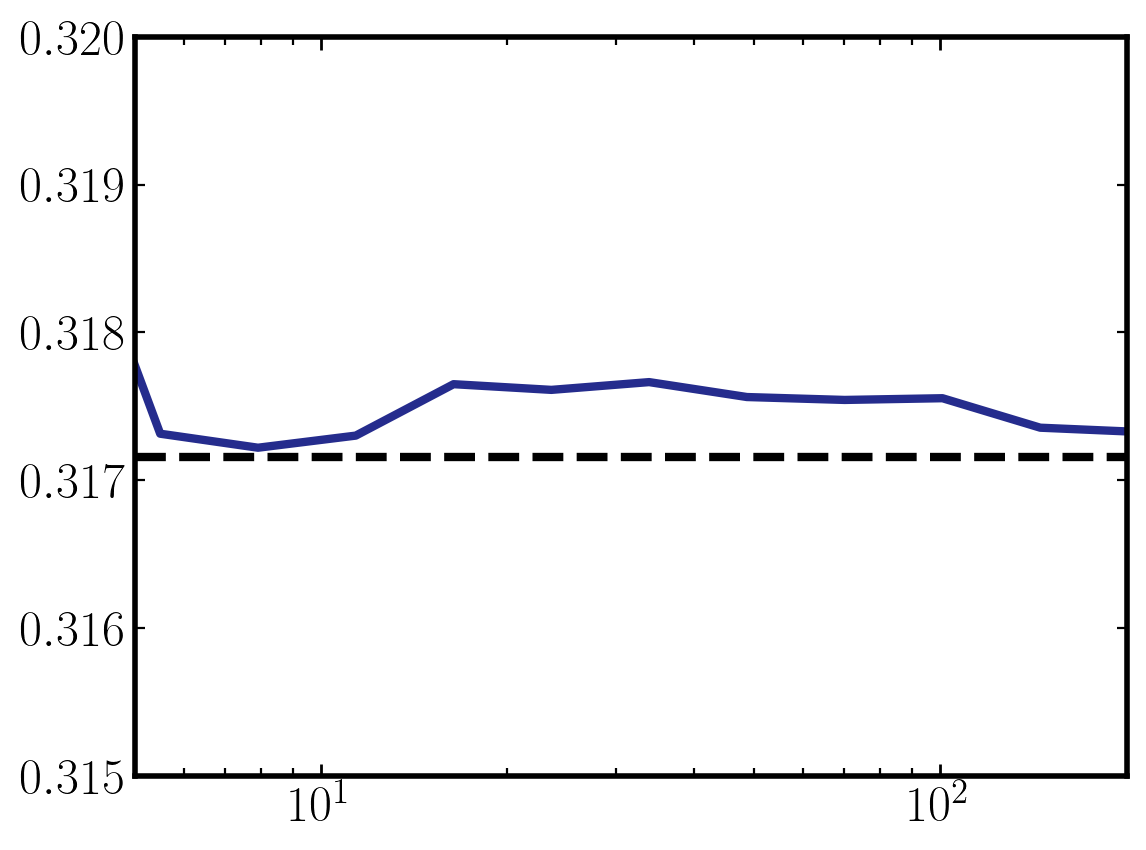

In [81]:
plt.plot(out_lowz[0], out_lowz[-1])
plt.axhline(np.average(res), ls="--", color="black")
plt.xscale("log")
plt.xlim(5, 200)
plt.ylim(0.315, 0.320)

(0.315, 0.32)

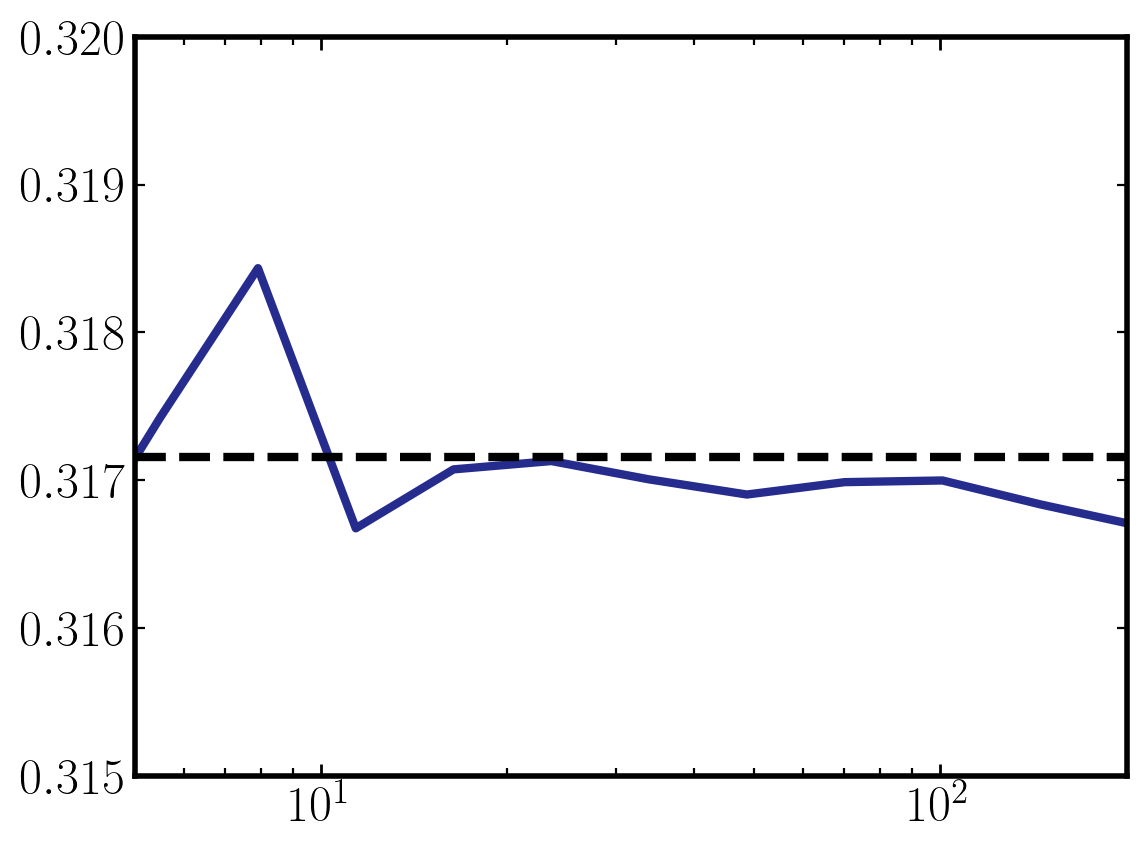

In [82]:
plt.plot(out_cmass1[0], out_cmass1[-1])
plt.axhline(np.average(res), ls="--", color="black")
plt.xscale("log")
plt.xlim(5, 200)
plt.ylim(0.315, 0.320)

(0.315, 0.32)

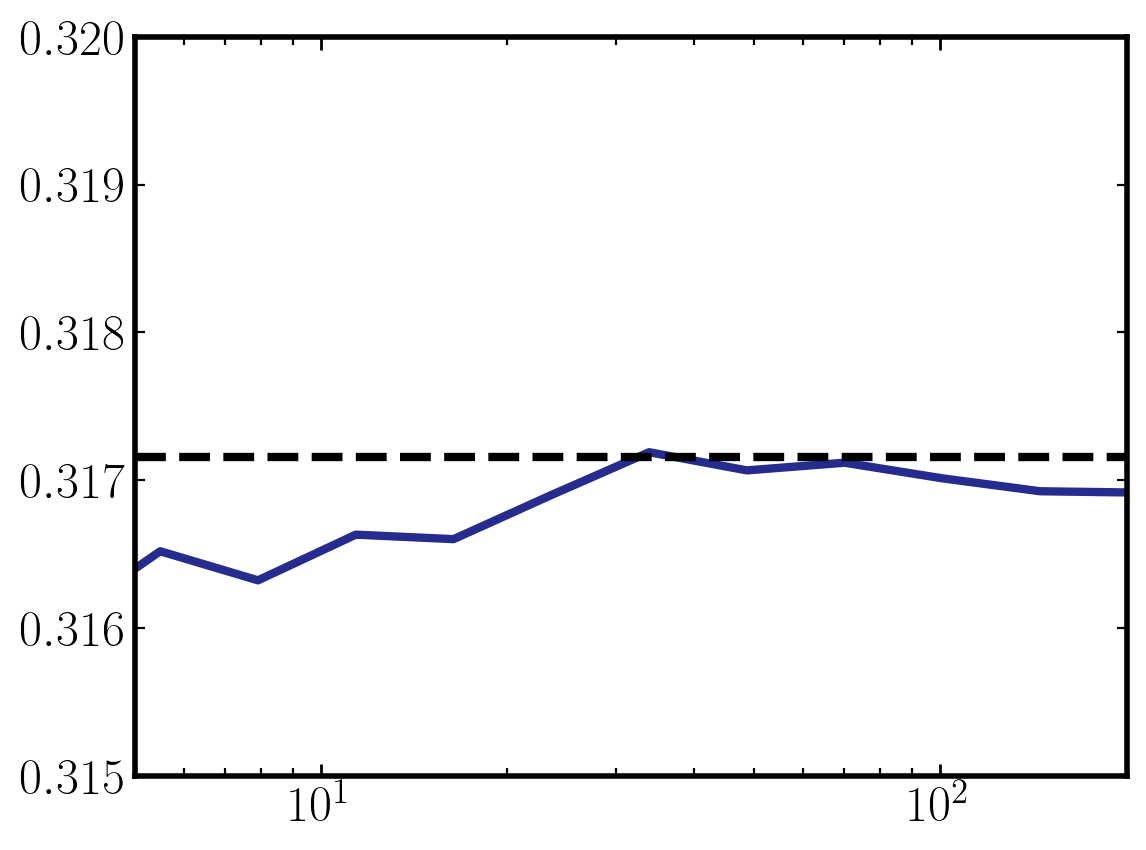

In [83]:
plt.plot(out_cmass2[0], out_cmass2[-1])
plt.axhline(np.average(res), ls="--", color="black")
plt.xscale("log")
plt.xlim(5, 200)
plt.ylim(0.315, 0.320)

In [77]:
cor = treecorr.KKCorrelation(
    nbins=20, min_sep=0.25, max_sep=360.0, sep_units="arcmin"
)
cor.process(catk, catk)

(5, 200)

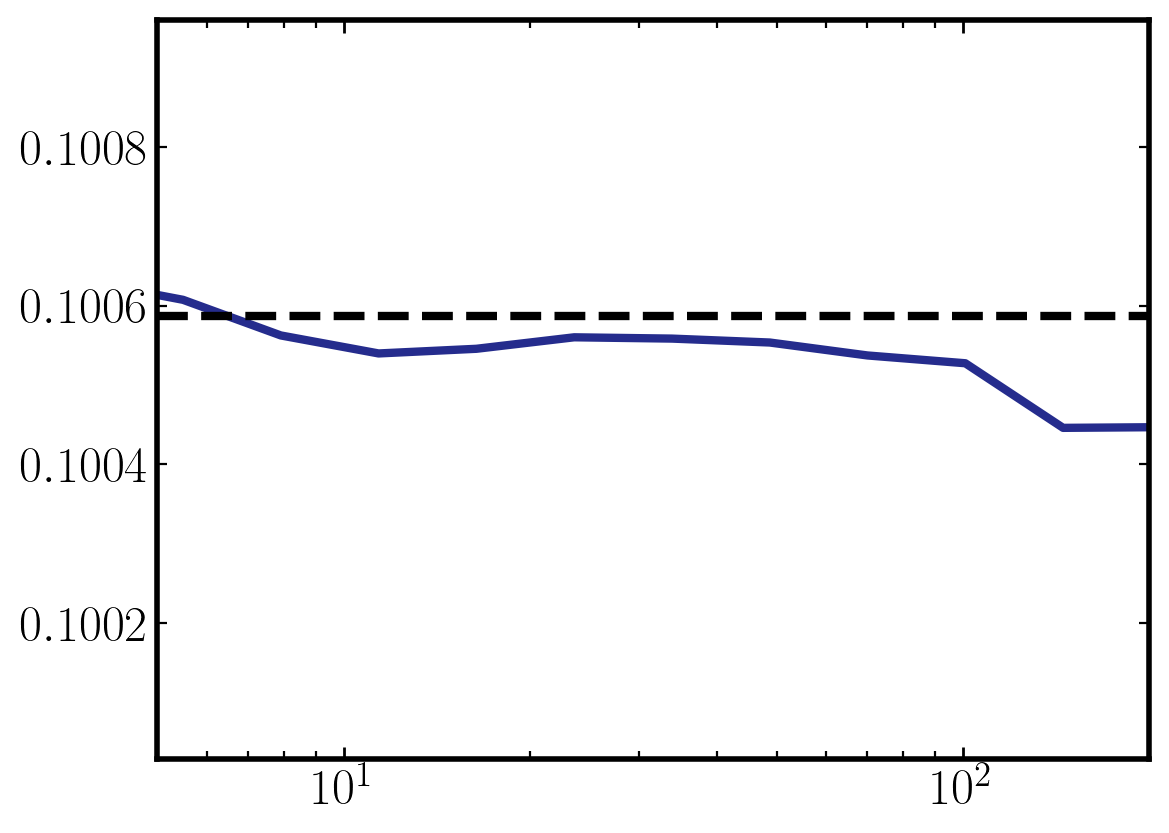

In [78]:
plt.plot(cor.rnom, cor.xi)
plt.axhline(np.average(res) * np.average(res), ls="--", color="black")
plt.xscale("log")
plt.xlim(5, 200)